### Heart Attack Analysis & Prediction 

#### download a dataset from Kaggle

In [31]:
# install the Kaggle API client:
# !pip install kaggle\

# to ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
# upload  Kaggle API key:
!mkdir -p ~/.kaggle
!echo '{"username":"ahmadsoliman94","key":"ffb7c90fc4521d202ca247af6493f9ad"}' > ~/.kaggle/kaggle.json

In [33]:
# download the dataset:
!kaggle datasets download -d rashikrahmanpritom/heart-attack-analysis-prediction-dataset

/bin/bash: kaggle: command not found


#### unizip the dataset

In [34]:
import zipfile

# Open the zip file
with zipfile.ZipFile("heart-attack-analysis-prediction-dataset.zip", "r") as zip_ref:
    # Extract all the contents of the zip file
    zip_ref.extractall("dataset/")

##### About the dataset: 
- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- ca: number of major vessels (0-3)
- cp : Chest Pain type chest pain type:
* Value 1: typical angina
* Value 2: atypical angina
* Value 3: non-anginal pain
* Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results:
* Value 0: normal
* Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* thalach : maximum heart rate achieved
* output : 0= less chance of heart attack 1= more chance of heart attack
#### In this notebook, various machine learning algorithms will be applied and try to predict the Heart Attack.

### Import the necessary libraries


In [165]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix

import xgboost as xgb

#### Load the data into a Pandas DataFrame

In [36]:
def load_data(path):
    dataframe = pd.read_csv(path)
    return dataframe

In [37]:
df_path = os.getcwd() + '/dataset/heart.csv'

In [38]:
df = load_data(os.getcwd() + '/dataset/heart.csv')

In [39]:
df.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

### Explore the data

In [40]:
'''
in this function i will use two medtods:
describe(): is used for calculating some statistical data like percentile, mean and std of the numerical values.
info(): this method prints information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.
'''

def explore_dataset(dataframe):
    display(dataframe.describe())
    print('\n\n')
    dataframe.info()

In [41]:
explore_dataset(df)

age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

            thall      output  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


#### * of the outputs above we can observe, that there are no missing values and no object datatype. 

#### show the correlations between variables

In [42]:
'''
in this function we will: 
1. Compute the correlation matrix
2. Set up the matplotlib figure
3. Draw the heatmap 
'''

def show_corr(dataframe): 
    correlation = dataframe.corr()
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(correlation,annot=True)
    return correlation

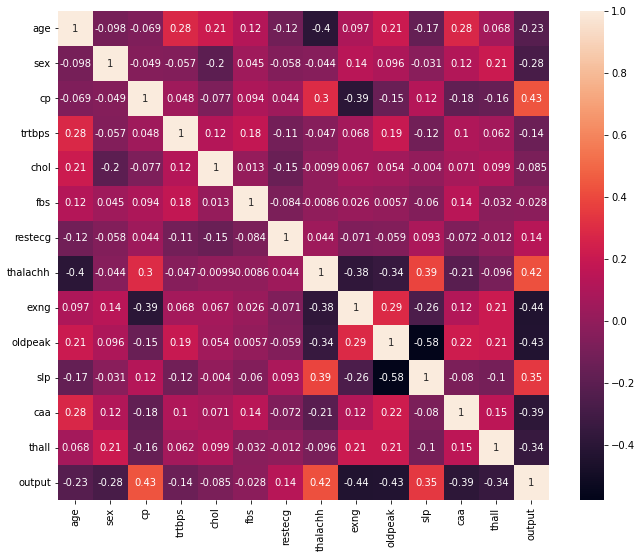

In [43]:
corr = show_corr(df)

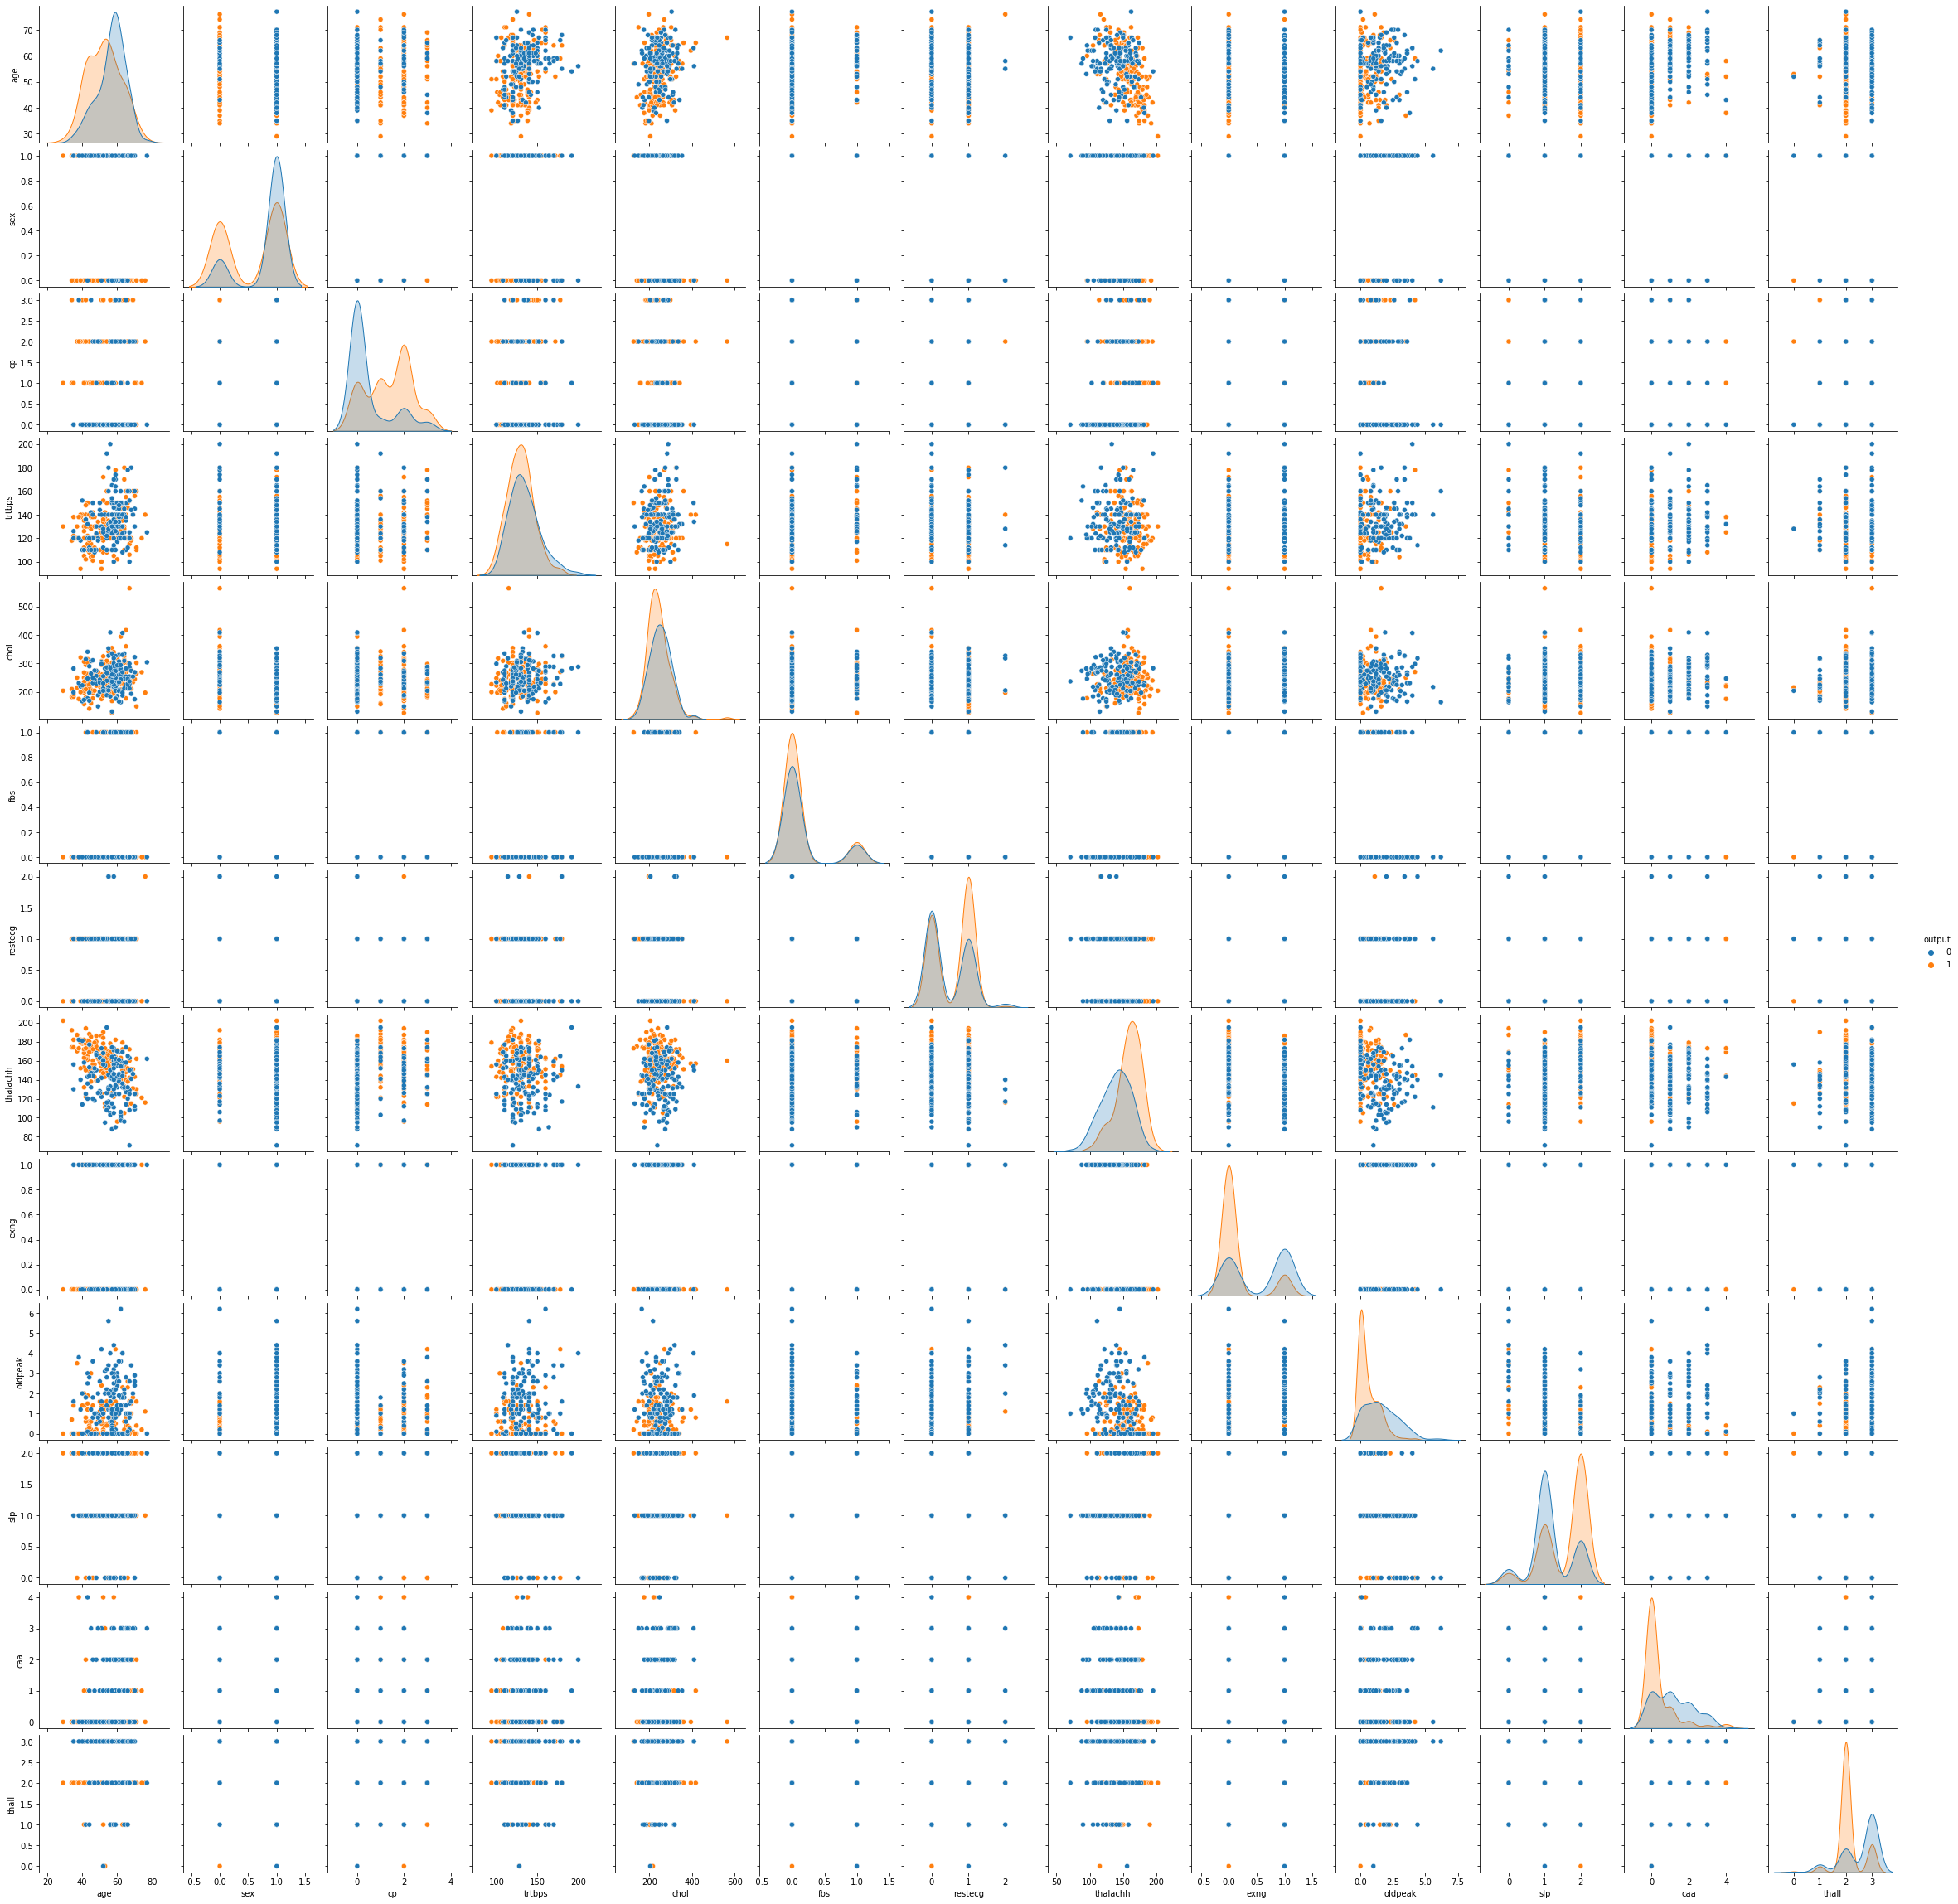

In [44]:
# pairplot to visualize the relationships between variables and identify any trends or patterns in the data.
sns.pairplot(df,hue='output')

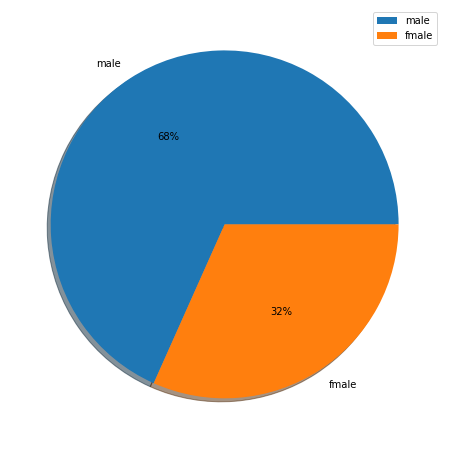

In [46]:
# to observe the sex of the patient
label = ['male','fmale']
data = df['sex'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(data,labels=label,autopct='%.0f%%',shadow=True,)
plt.legend()
plt.show()

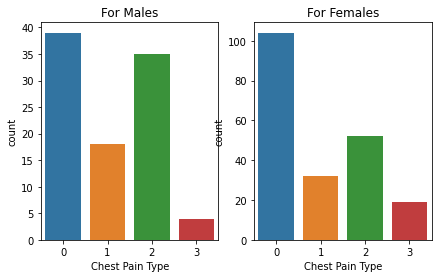

In [16]:
# Let's see how chest pain type varies according to gender.
fig, axs = plt.subplots(1, 2, figsize=(7, 4))

sns.countplot(data=df[df['sex']==0], x='cp', ax=axs[0])
axs[0].set(title="For Males")
axs[0].set(xlabel="Chest Pain Type")
sns.countplot(data=df[df['sex']==1], x='cp', ax=axs[1])
axs[1].set(title="For Females")
axs[1].set(xlabel="Chest Pain Type")

plt.show()

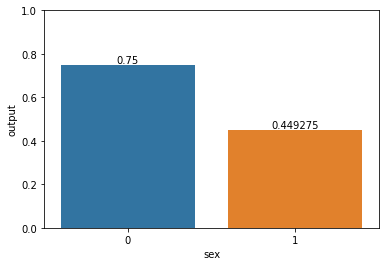

In [17]:
# observe the risk of heart attack according to gender.
fig, ax = plt.subplots()
sns.barplot(data=df, x='sex', y='output', estimator=np.mean, ci=None, ax=ax) # ci: Size of confidence intervals to draw around estimated values.
ax.bar_label(ax.containers[0])
ax.set_ylim((0, 1))
plt.show()

- Most males in this dataset are at risk of heart attack (75%). About half (44%) of females are at risk

### Check the outliers

In [18]:
'''
in this function i will try to detect outliers and visualize them
'''

def detect_outliers(dataframe):
    
    count = 0
    
    # Calculate Q1 and Q3 for each column
    for column in df.columns:
        Q1 , Q3 = np.quantile(dataframe[column], 0.25), np.quantile(dataframe[column], 0.75)
        
        # calculate the IQR
        IQR = Q3 - Q1
        # calculate the outlier cutoff
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)
        
        # calculate the lower and upper bound value
        print(f'column name: {column}')
        print('The IQR is',IQR)
        print('The lower bound value is', lower_range)
        print('The upper bound value is', upper_range)
        
        # Identify outliers
        df1 = dataframe[dataframe[column] > upper_range]
        df2 = dataframe[dataframe[column] < lower_range]
        outliers = df1.shape[0]+ df2.shape[0]
        print(f'Total number of outliers: {outliers}' )
        print('----------------------------------------------------------------------')
        count +=1
    
    # Visualize the outliers
    plt.figure(figsize=(10,10))
    sns.boxplot(data=dataframe)
    plt.show()
        
        

column name: age
The IQR is 13.5
The lower bound value is 27.25
The upper bound value is 81.25
Total number of outliers: 0
----------------------------------------------------------------------
column name: sex
The IQR is 1.0
The lower bound value is -1.5
The upper bound value is 2.5
Total number of outliers: 0
----------------------------------------------------------------------
column name: cp
The IQR is 2.0
The lower bound value is -3.0
The upper bound value is 5.0
Total number of outliers: 0
----------------------------------------------------------------------
column name: trtbps
The IQR is 20.0
The lower bound value is 90.0
The upper bound value is 170.0
Total number of outliers: 9
----------------------------------------------------------------------
column name: chol
The IQR is 63.5
The lower bound value is 115.75
The upper bound value is 369.75
Total number of outliers: 5
----------------------------------------------------------------------
column name: fbs
The IQR is 0.0
Th

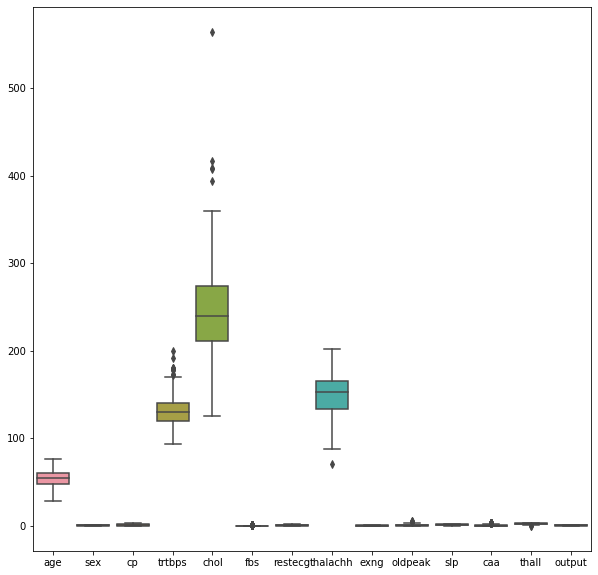

In [19]:
detect_outliers(df)

### Check for duplicated rows

In [20]:
duplicated_rows = df.duplicated(subset=df.columns, keep=False)
# Print the duplicated rows
print(df[duplicated_rows])

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
163   38    1   2     138   175    0        1       173     0      0.0    2   
164   38    1   2     138   175    0        1       173     0      0.0    2   

     caa  thall  output  
163    4      2       1  
164    4      2       1  


In [21]:
df.drop_duplicates(inplace=True)

In [22]:
duplicated_rows = df.duplicated(subset=df.columns, keep=False)
# Print the duplicated rows
print(df[duplicated_rows])

Empty DataFrame
Columns: [age, sex, cp, trtbps, chol, fbs, restecg, thalachh, exng, oldpeak, slp, caa, thall, output]
Index: []


### show the variables that are correlated with the target >= 10% and drop the rest

In [23]:
corr

age       sex        cp    trtbps      chol       fbs  \
age       1.000000 -0.098447 -0.068653  0.279351  0.213678  0.121308   
sex      -0.098447  1.000000 -0.049353 -0.056769 -0.197912  0.045032   
cp       -0.068653 -0.049353  1.000000  0.047608 -0.076904  0.094444   
trtbps    0.279351 -0.056769  0.047608  1.000000  0.123174  0.177531   
chol      0.213678 -0.197912 -0.076904  0.123174  1.000000  0.013294   
fbs       0.121308  0.045032  0.094444  0.177531  0.013294  1.000000   
restecg  -0.116211 -0.058196  0.044421 -0.114103 -0.151040 -0.084189   
thalachh -0.398522 -0.044020  0.295762 -0.046698 -0.009940 -0.008567   
exng      0.096801  0.141664 -0.394280  0.067616  0.067023  0.025665   
oldpeak   0.210013  0.096093 -0.149230  0.193216  0.053952  0.005747   
slp      -0.168814 -0.030711  0.119717 -0.121475 -0.004038 -0.059894   
caa       0.276326  0.118261 -0.181053  0.101389  0.070511  0.137979   
thall     0.068001  0.210041 -0.161736  0.062210  0.098803 -0.032019   
output   -0.225439 -0.280937  0.433798 -0.144931 -0.085239 -0.028046   

           restecg  thalachh      exng   oldpeak       slp       caa  \
age      -0.116211 -0.398522  0.096801  0.210013 -0.168814  0.276326   
sex      -0.058196 -0.044020  0.141664  0.096093 -0.030711  0.118261   
cp        0.044421  0.295762 -0.394280 -0.149230  0.119717 -0.181053   
trtbps   -0.114103 -0.046698  0.067616  0.193216 -0.121475  0.101389   
chol     -0.151040 -0.009940  0.067023  0.053952 -0.004038  0.070511   
fbs      -0.084189 -0.008567  0.025665  0.005747 -0.059894  0.137979   
restecg   1.000000  0.044123 -0.070733 -0.058770  0.093045 -0.072042   
thalachh  0.044123  1.000000 -0.378812 -0.344187  0.386784 -0.213177   
exng     -0.070733 -0.378812  1.000000  0.288223 -0.257748  0.115739   
oldpeak  -0.058770 -0.344187  0.288223  1.000000 -0.577537  0.222682   
slp       0.093045  0.386784 -0.257748 -0.577537  1.000000 -0.080155   
caa      -0.072042 -0.213177  0.115739  0.222682 -0.080155  1.000000   
thall    -0.011981 -0.096439  0.206754  0.210244 -0.104764  0.151832   
output    0.137230  0.421741 -0.436757 -0.430696  0.345877 -0.391724   

             thall    output  
age       0.068001 -0.225439  
sex       0.210041 -0.280937  
cp       -0.161736  0.433798  
trtbps    0.062210 -0.144931  
chol      0.098803 -0.085239  
fbs      -0.032019 -0.028046  
restecg  -0.011981  0.137230  
thalachh -0.096439  0.421741  
exng      0.206754 -0.436757  
oldpeak   0.210244 -0.430696  
slp      -0.104764  0.345877  
caa       0.151832 -0.391724  
thall     1.000000 -0.344029  
output   -0.344029  1.000000

In [24]:
corr_vars = corr[abs(corr['output']) > 0.40]['output'].index
print(corr_vars)

Index(['cp', 'thalachh', 'exng', 'oldpeak', 'output'], dtype='object')


In [50]:
df = df[corr_vars]

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cp        303 non-null    int64  
 1   thalachh  303 non-null    int64  
 2   exng      303 non-null    int64  
 3   oldpeak   303 non-null    float64
 4   output    303 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 12.0 KB


#### Split the data into train and test

In [52]:
X = df.drop('output', axis=1) # Whether to drop labels from the index (0 or 'index') or columns (1 or 'columns').
y = df['output']

X.shape, y.shape

((303, 4), (303,))

In [29]:
'''
to split data and print the shape of them
'''
def split_data(x,y,test_size,random_state=None):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size,random_state=random_state)
    print(f'Shape of X train: {x_train.shape}')
    print(f'Shape of y train: {y_train.shape}')
    print(f'Shape of X test: {x_test.shape}')
    print(f'Shape of y test: {y_test.shape}')
    return x_train, x_test, y_train, y_test

In [88]:
X_train, X_test, y_train, y_test = split_data(X,y,test_size=0.2,random_state=0)

Shape of X train: (242, 4)
Shape of y train: (242,)
Shape of X test: (61, 4)
Shape of y test: (61,)


#### Selecting models

In [100]:
'''
in this function i will choose various classification algorthims then iset up pipeline for model and scaler. 
I will apply k-fold cross validation for data and trying to tuning the hyperparameters as well 
then evaluate the model peformance using accuracy_score.

'''

def build_model(x_train, y_train,x_test,y_test,model,scaler,hyperparameter,metric=''):
    
    # Set up the pipeline with the scaler and the model
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', model)
    ])

    # Set up the hyperparameter grid to search over
    param_grid = hyperparameter

    # Set up the K-fold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Set up the grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=metric)

    # Fit the grid search to the data
    grid_search.fit(x_train, y_train)

    # Print the best hyperparameters
    print("Best hyperparameters:", grid_search.best_params_)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Evaluate the model using the best hyperparameters
    model_prediction = best_model.predict(x_test)
    model_acc = accuracy_score(y_test, model_prediction)
    print(f" accuracy :{model_acc}" )
    
    return model_prediction, model_acc

In [121]:
'''
1. print classification report.
2. disply confusionmatrix
'''
def visualize_prediction(y_test,model_prediction,labels=None):
    print(classification_report(y_test, model_prediction))
    cm = confusion_matrix(y_test, model_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()

### Logistic Regression

In [122]:
model = LogisticRegression(random_state=42)
# model.get_params()

In [123]:
scaler = RobustScaler()

hyperparameter = {
     
    'model__penalty':[None,'l2','l1'],
    'model__fit_intercept':[True,False]
}

metric = 'accuracy'


In [124]:
log_pred, log_acc = build_model(X_train, y_train,X_test,y_test,model=model,scaler=scaler,hyperparameter=hyperparameter,metric=metric)

Best hyperparameters: {'model__fit_intercept': True, 'model__penalty': 'l2'}
 accuracy :0.8688524590163934


              precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           1       0.86      0.91      0.89        34

    accuracy                           0.87        61
   macro avg       0.87      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61



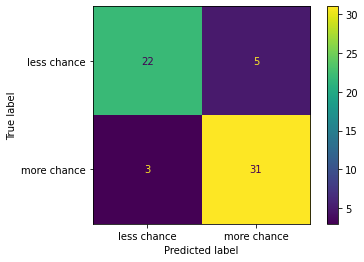

In [125]:
visualize_prediction(y_test,log_pred,labels=['less chance','more chance'])

#### KNeighbors classifier

In [130]:
np.random.seed(42)

model = KNeighborsClassifier()
# model.get_params()

In [134]:
scaler = RobustScaler()

hyperparameter = {
    'model__n_neighbors':[5,6,7,8,9],
    'model__weights':['uniform','distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

metric = 'accuracy'


In [135]:
knn_pred, knn_acc = build_model(X_train, y_train,X_test,y_test,model=model,scaler=scaler,hyperparameter=hyperparameter,metric=metric)

Best hyperparameters: {'model__algorithm': 'auto', 'model__n_neighbors': 9, 'model__weights': 'uniform'}
 accuracy :0.8032786885245902


              precision    recall  f1-score   support

           0       0.83      0.70      0.76        27
           1       0.79      0.88      0.83        34

    accuracy                           0.80        61
   macro avg       0.81      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61



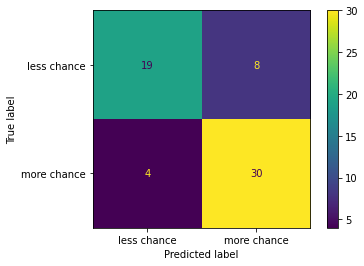

In [133]:
visualize_prediction(y_test,knn_pred,labels=['less chance','more chance'])

### SVM classifier

In [139]:
np.random.seed(42)

model = SVC()
#odel.get_params()

In [140]:
scaler = RobustScaler()

hyperparameter = {
    'model__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'model__max_iter':[20,30,50,100,-1],
    'model__gamma': ['auto', 'scale']
}

metric = 'accuracy'

In [141]:
svm_pred, svm_acc = build_model(X_train, y_train,X_test,y_test,model=model,scaler=scaler,hyperparameter=hyperparameter,metric=metric)

Best hyperparameters: {'model__gamma': 'auto', 'model__kernel': 'linear', 'model__max_iter': 100}
 accuracy :0.819672131147541


              precision    recall  f1-score   support

           0       0.90      0.67      0.77        27
           1       0.78      0.94      0.85        34

    accuracy                           0.82        61
   macro avg       0.84      0.80      0.81        61
weighted avg       0.83      0.82      0.81        61



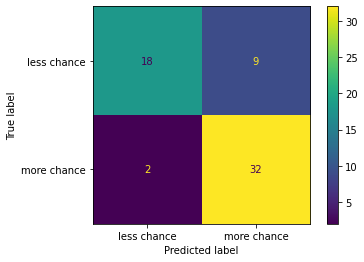

In [142]:
visualize_prediction(y_test,svm_pred,labels=['less chance','more chance'])

### DecisionTree Classifier

In [146]:
np.random.seed(42)

model = DecisionTreeClassifier()
# model.get_params()

In [147]:
scaler = RobustScaler()

hyperparameter = {
    'model__criterion':['gini', 'entropy', 'log_loss'],
    'model__splitter':['random', 'best'],
    'model__min_samples_split': [2,4,6,8],
    'model__max_leaf_nodes':[4,5,6,7]
                       
}

metric = 'accuracy'

In [148]:
dt_pred, dt_acc = build_model(X_train, y_train,X_test,y_test,model=model,scaler=scaler,hyperparameter=hyperparameter,metric=metric)

Best hyperparameters: {'model__criterion': 'log_loss', 'model__max_leaf_nodes': 6, 'model__min_samples_split': 6, 'model__splitter': 'random'}
 accuracy :0.7377049180327869


              precision    recall  f1-score   support

           0       0.67      0.81      0.73        27
           1       0.82      0.68      0.74        34

    accuracy                           0.74        61
   macro avg       0.74      0.75      0.74        61
weighted avg       0.75      0.74      0.74        61



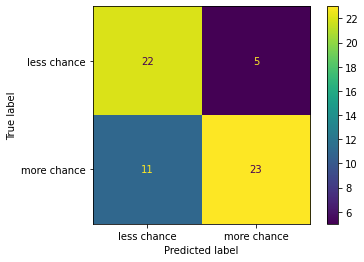

In [150]:
visualize_prediction(y_test,dt_pred,labels=['less chance','more chance'])

#### RandomForest Classifier

In [156]:
model = RandomForestClassifier(random_state=42)
# model.get_params()

In [154]:
scaler = RobustScaler()

hyperparameter = {
    'model__n_estimators':[100,200,300],
    'model__criterion':['gini','entropy'],
    'model__max_depth':[3,4,5,6,7,8,9],
    'model__bootstrap' : [True, False],
    'model__min_samples_split': [2,4,6,8]

}

metric = 'accuracy'

In [155]:
rf_pred, rf_acc = build_model(X_train, y_train,X_test,y_test,model=model,scaler=scaler,hyperparameter=hyperparameter,metric=metric)

Best hyperparameters: {'model__bootstrap': True, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200}
 accuracy :0.819672131147541


              precision    recall  f1-score   support

           0       0.83      0.74      0.78        27
           1       0.81      0.88      0.85        34

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.81        61
weighted avg       0.82      0.82      0.82        61



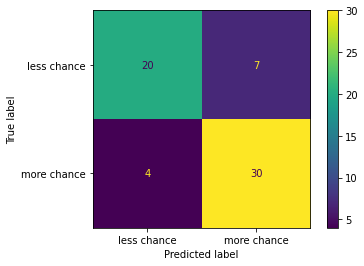

In [157]:
visualize_prediction(y_test,rf_pred,labels=['less chance','more chance'])

### XGB Classifier

In [159]:
model = xgb.XGBClassifier(objective = 'binary:logistic',random_state=42)

In [170]:
scaler = RobustScaler()

hyperparameter = {'model__n_estimators': [50,100,150, 300],
              'model__eta': [0.01, 0.002,0.0003,0.3],
              'model__subsample': [0.3, 0.01,0.5],
              'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
              'model__colsample_bytree': [0.5, 0.4,0.6],
              'model__min_child_weight': [1, 2, 3, 4]
             }

metric = 'accuracy'

In [171]:
xgb_pred, xgb_acc = build_model(X_train, y_train,X_test,y_test,model=model,scaler=scaler,hyperparameter=hyperparameter,metric=metric)

Best hyperparameters: {'model__colsample_bytree': 0.5, 'model__eta': 0.002, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 50, 'model__subsample': 0.3}
 accuracy :0.819672131147541


              precision    recall  f1-score   support

           0       0.86      0.70      0.78        27
           1       0.79      0.91      0.85        34

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



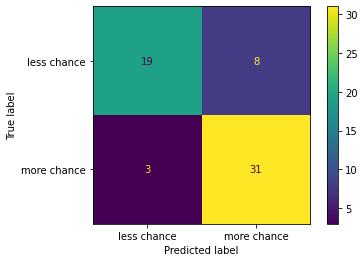

In [172]:
visualize_prediction(y_test,xgb_pred,labels=['less chance','more chance'])

<AxesSubplot:>

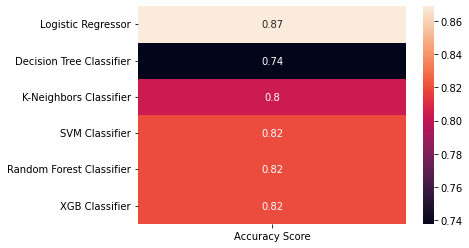

In [174]:
scores = [log_acc,dt_acc,knn_acc,svm_acc,rf_acc,xgb_acc]
labels = ['Logistic Regressor', 'Decision Tree Classifier', 'K-Neighbors Classifier', 'SVM Classifier','Random Forest Classifier','XGB Classifier']
accs = {'Accuracy Score': scores}
df = pd.DataFrame(accs,index=labels)

sns.heatmap(df,annot=True)